In [28]:
# Mounting the google drive to get the images

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential, losses
import matplotlib.pyplot as plt
import numpy as np
import os

import warnings

warnings.filterwarnings('ignore')

In [30]:
def get_train_test_split_tf(ds,
                             train_split = 0.8,
                             val_split = 0.1,
                             shuffle = True,
                             shuffle_size = 1000):
    
    ds_size = len(ds)
    
    if shuffle:
        
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

def predict(model,img,class_names):

  img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
  img_array = tf.expand_dims(img_array,0)

  prediction = model.predict(img_array)

  predicted_class = class_names[np.argmax(prediction[0])]
  confidence = round(100 * (np.max(prediction[0])),2)

  return predicted_class,confidence

In [31]:
!ls drive/MyDrive/potato_project

charts	data  models


In [32]:
file_path = 'drive/MyDrive/potato_project'
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 256

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(file_path + '/data',
                                                              shuffle = True,
                                                              image_size = (IMG_SIZE,IMG_SIZE),
                                                              batch_size = BATCH_SIZE
                                                             )

Found 2152 files belonging to 3 classes.


In [34]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [35]:
len(dataset)

68

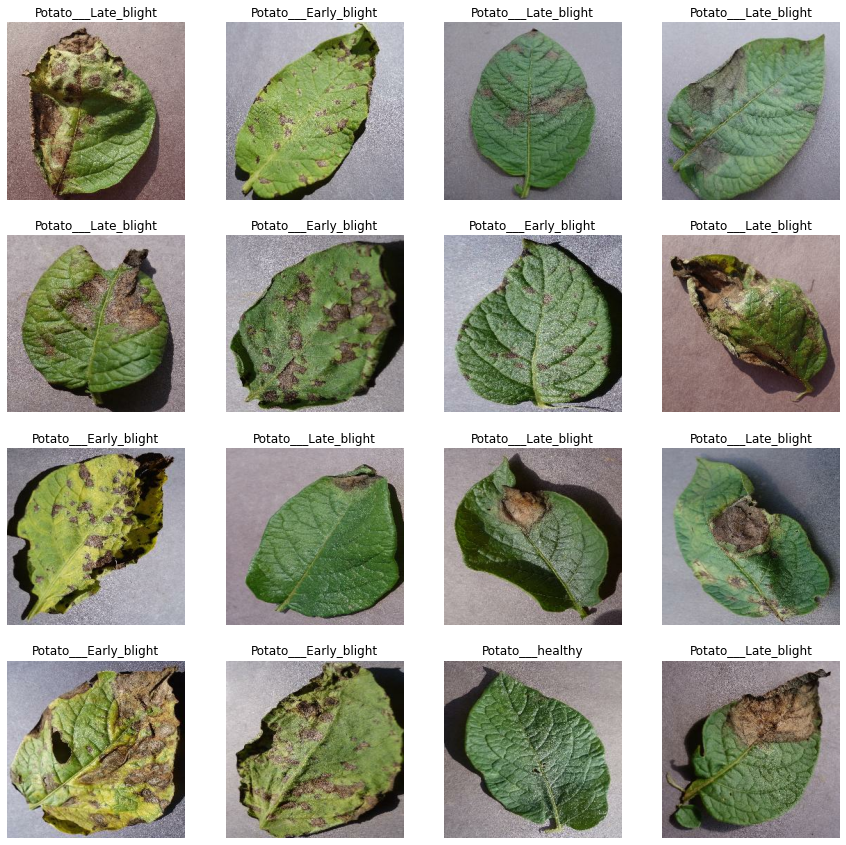

In [36]:
for img_batch,label_batch in dataset.take(1):
    fig = plt.figure(figsize=(15,15))
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(img_batch[i].numpy().astype('uint'))
        plt.axis('off')

    fig.savefig(file_path + f'/charts/different_potato_images.jpg')


In [37]:
train_ds,val_ds,test_ds = get_train_test_split_tf(dataset,shuffle = True)

In [38]:
len(train_ds)

54

In [39]:
len(val_ds)

6

In [40]:
len(test_ds)

8

In [41]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [42]:
resize_and_rescale = Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [43]:
for img_batch,label_batch in dataset.take(1):
  batch,img_size,img_size,channels = img_batch.shape
  print(img_batch.shape)

(32, 256, 256, 3)


In [44]:
len(class_names)

3

In [45]:
input_shape = (batch,img_size,img_size,channels)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu',),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
])

model.build(input_shape = input_shape)

In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [47]:
model.compile(
    optimizer = 'adam',
    loss = losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [48]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 14s 170ms/step - loss: 0.9037 - accuracy: 0.4809 - val_loss: 0.8513 - val_accuracy: 0.5156
Epoch 2/50
54/54 [==============================] - 5s 93ms/step - loss: 0.7256 - accuracy: 0.6412 - val_loss: 0.8089 - val_accuracy: 0.5990
Epoch 3/50
54/54 [==============================] - 5s 93ms/step - loss: 0.5239 - accuracy: 0.7627 - val_loss: 0.3784 - val_accuracy: 0.8490
Epoch 4/50
54/54 [==============================] - 5s 93ms/step - loss: 0.3503 - accuracy: 0.8507 - val_loss: 0.5990 - val_accuracy: 0.8021
Epoch 5/50
54/54 [==============================] - 5s 94ms/step - loss: 0.2666 - accuracy: 0.8941 - val_loss: 0.2160 - val_accuracy: 0.9271
Epoch 6/50
54/54 [==============================] - 5s 94ms/step - loss: 0.1984 - accuracy: 0.9259 - val_loss: 0.1919 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 5s 94ms/step - loss: 0.1897 - accuracy: 0.9271 - val_loss: 0.3497 - val_accuracy: 0.8854
Epoch 8/50


In [49]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

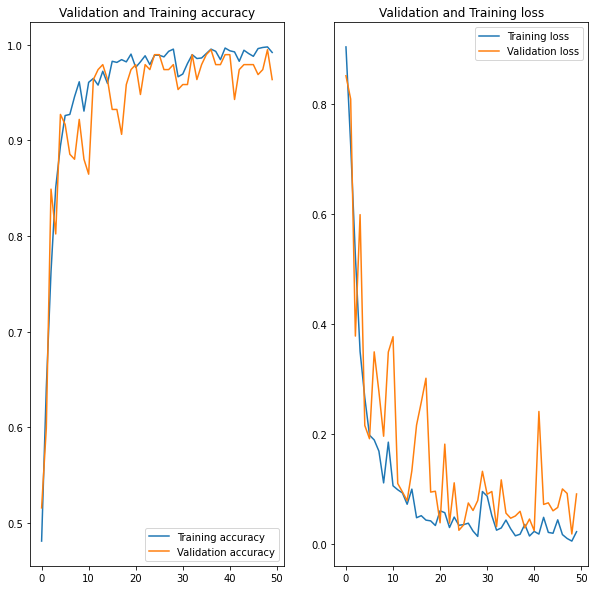

In [51]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Validation and Training accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Validation and Training loss')

fig.savefig(file_path + f'/charts/validation_and_training_losses.jpg')

1/1 [==============================] - 0s 100ms/step
Actual label:  Potato___Late_blight
Predicted label:  Potato___Late_blight


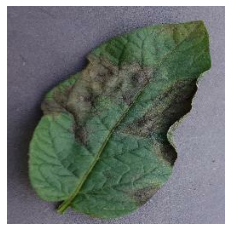

In [52]:
for img_batch,label_batch in train_ds.take(1):

  first_img = img_batch[0].numpy().astype('uint')
  first_label = label_batch[0].numpy()
  batch_prediction = model.predict(img_batch)
  print('Actual label: ', class_names[first_label])
  print('Predicted label: ', class_names[np.argmax(batch_prediction[0])])
  plt.imshow(first_img)
  plt.axis('off')

  plt.savefig(file_path + f'/charts/single_image_prediction.jpg')

1/1 [==============================] - 0s 20ms/step


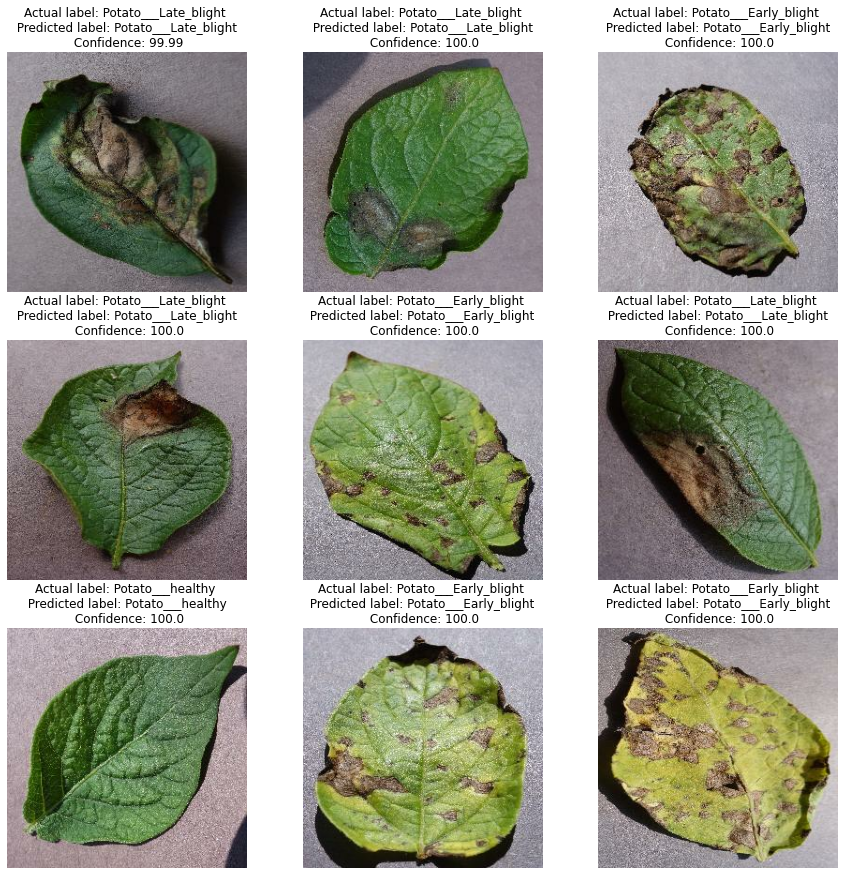

In [66]:
plt.figure(figsize=(15,15))

for image_batch,labels_batch in dataset.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint'))

    predicted_class, confidence = predict(model,
                                          image_batch[i],
                                          class_names
                                          )
    
    plt.title('Actual label: {} \n Predicted label: {} \n Confidence: {}'.format(
        class_names[labels_batch[i].numpy()],
        predicted_class,
        confidence
    ))

    plt.axis('off')

    fig.savefig(file_path + f'/charts/multiple_images_prediction.jpg')

In [ ]:
model_version = max([int(i) for i in os.listdir(file_path + '/models') + [0]]) + 1
model.save(file_path + f'/models/{model_version}')

In [68]:
!ls drive/MyDrive/potato_project/models

1  2  3  4
